# **Обучение с подкреплением: OpenAI gym, CrossEntropy Method (CEM).**

## **1. OpenAI gym**

In [1]:
#######################################
# Shell package installer and checker #
#######################################

%%shell

function echo_sep ( ) {
  echo "-----------------------------------------------------------------------------------"
}

function install_pip( ) {
  install_res=1;
  echo "pip - installing package $1"
  pip -q install $1$2

  if pip list -v | grep $1; then
    echo "pip package $1 install success"
    install_res=0
  else
    echo "pip package $1 install failed"
  fi

  echo_sep

  return $install_res;
}

function install_apt( ) {
  install_res=1
  echo "apt-get - installing package $1"
  apt-get -qq install $1

  if apt list -v 2>/dev/null | grep $1; then
    echo "apt package $1 install success" 
    install_res=0
  else 
    echo "apt package $1 install failed"
  fi

  echo_sep

  return $install_res;
}

function install_ln( ) {
  install_res=1;
  echo "symlink ln -snf - init $1 to $2"
  ln -snf $1 $2

  if [[ -L $2 ]]; then
    install_res=0
    echo "symlink success"
  else
    echo "symlink failed"
  fi

  echo_sep

  return $install_res;
}


function install_all() { 
  # Use && to consequently check package installation
  # apt install section
  install_apt 'libnvtoolsext1'             &&
  install_apt 'xvfb'                       &&
  install_apt 'freeglut3-dev'              &&
  install_apt 'ffmpeg'                     &&
  install_apt 'x11-utils'                  &&
  # pip install section
  install_pip 'gym'                        &&
  install_pip 'pyglet'                     &&
  install_pip 'PyOpenGL'                   &&
  install_pip 'PyVirtualDisplay' '==0.2.5' &&
  # ln install
  install_ln '/usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0' '/usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so' &&
  echo "All packages installed" && echo_sep && echo
} 


install_all


apt-get - installing package libnvtoolsext1
Selecting previously unselected package libnvtoolsext1:amd64.
(Reading database ... 146374 files and directories currently installed.)
Preparing to unpack .../libnvtoolsext1_9.1.85-3ubuntu1_amd64.deb ...
Unpacking libnvtoolsext1:amd64 (9.1.85-3ubuntu1) ...
Setting up libnvtoolsext1:amd64 (9.1.85-3ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.3) ...
/sbin/ldconfig.real: /usr/local/lib/python3.6/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

libnvtoolsext1/bionic,now 9.1.85-3ubuntu1 amd64 [installed]
apt package libnvtoolsext1 install success
-----------------------------------------------------------------------------------
apt-get - installing package xvfb
Selecting previously unselected package xvfb.
(Reading database ... 146380 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.8_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.8) ...
Setting up xvfb (2:1.19.6-1ubunt

In [2]:
#######################################
# Import section                      #
#######################################

import os
import random
import gym
import multiprocessing   as mp_lib
import numpy             as np_lib
import matplotlib.pyplot as plt_lib
import matplotlib.animation

from multiprocessing  import Process
from IPython.display  import clear_output, HTML
from pyvirtualdisplay import Display

%matplotlib inline

In [3]:
#######################################
# Init virtual display                #
#######################################

display = Display( visible = 0, 
                   size    = ( 1024, 768 ) )
display.start()

os.environ[ "DISPLAY" ] = ":" + str( display.display ) + "."  + str( display.screen )

## **2. Crossentropy Method**

In [4]:
#######################################
# Enviroment setup                    #
#######################################
# Результаты зависят от среды         #
#######################################

env = gym.make( "Taxi-v3" )
env.reset()
env.render()

n_states  = env.observation_space.n
n_actions = env.action_space.n  

print( f"observations: { n_states } \nactions:      { n_actions }" )

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

observations: 500 
actions:      6


**Инициализация вспомогательных функций**

In [5]:
#######################################
# Functions def                       #
#######################################

def initialize_policy( n_states, n_actions ):
  policy = [ [ 1/n_actions for _ in range( n_actions ) ] for _ in range( n_states ) ]
  return np_lib.array( policy )


"""
Игра идет до конца эпизода или до t_max шагов в окружении. 
:param policy: [ n_states, n_actions ] 
:returns: states       - список состояний, 
          actions      - список действий, 
          total_reward - итоговое вознаграждение
"""
def generate_session( env, policy, t_max=10**4 ):
  states, actions = [], []
  total_reward = 0.

  s = env.reset()

  for t in range( t_max ):
    # Выбираем действие согласно текущей стратегии
    # Подсказка: можно воспользоваться np.random.choice для сэмплирования действий
    # https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
    # a = 

    ####### Здесь ваш код ########## 
    a = np_lib.random.choice( list( range( n_actions ) ), p = policy[ s ] ) 
    ################################

    new_s, r, done, info = env.step( a )

    # Запоминаем нужную нам информацию
    states.append( s )
    actions.append( a )

    total_reward += r

    s = new_s

    if done: break

  return states, actions, total_reward


"""
Выбирает состояния и действия с заданным перцентилем ( rewards >= percentile )
:param states_batch : list of lists of states, states_batch[session_i][t]
:param actions_batch: list of lists of actions, actions_batch[session_i][t]
:param rewards_batch: list of rewards, rewards_batch[session_i]

:returns: elite_states  - одномерные списки состояния, выбранных сессий,
          elite_actions - одномерные списки  действия, выбранных сессий
"""
def select_elites( states_batch,  actions_batch, 
                   rewards_batch, percentile=50 ):
  # нужно найти порог вознаграждения по процентилю
  # reward_threshold =
  ####### Здесь ваш код ##########
  reward_threshold = np_lib.percentile( rewards_batch, percentile )
  ################################
  
  # в соответствии с найденным порогом - отобрать 
  # подходящие состояния и действия
  # elite_states = 
  # elite_actions = 
  ####### Здесь ваш код ##########
  elite_states  = [ transitions for i, transitions in enumerate( states_batch )  if rewards_batch[ i ] >= reward_threshold ]
  elite_actions = [ transitions for i, transitions in enumerate( actions_batch ) if rewards_batch[ i ] >= reward_threshold ]
  
  elite_states  = [ t for transitions in elite_states  for t in transitions ]
  elite_actions = [ t for transitions in elite_actions for t in transitions ]
  ################################
  
  return elite_states, elite_actions


"""
Новой стратегией будет:
policy[ s_i, a_i ] ~ #[ вхождения  si/ai в лучшие states/actions ]

Не забудьте про нормализацию состояний.
Если какое-то состояние не было посещено, 
то используйте равномерное распределение 1./n_actions

:param elite_states : список состояний
:param elite_actions: список действий
"""
def update_policy( elite_states, elite_actions, n_states, n_actions ):
  new_policy = np_lib.zeros( [ n_states, n_actions ] )
  # обновляем стратегию - нормируем новые частоты 
  # действий и не забываем про непосещенные состояния
  # new_policy[state, a] =         
  ####### Здесь ваш код ##########
  for i, state in enumerate( elite_states ):
    action = elite_actions[ i ]
    new_policy[ state, action ] += 1

  total_occur = new_policy.sum( axis = 1 )
  new_policy  = np_lib.where( [ [ d for _ in range( n_actions ) ] for d in total_occur > 0 ], 
                              new_policy,
                              np_lib.ones_like( new_policy ) )
  
  total_occur = new_policy.sum( axis = 1 )

  return np_lib.array( [ raw / total_occur[ i ] for i, raw in enumerate( new_policy ) ] )
  ################################

**Визуализириуем наш процесс обучения и также будем измерять распределение получаемых за сессию вознаграждений**

In [18]:
#######################################
# Visualize def                       #
#######################################

"""
Удобная функция, для визуализации результатов.
"""
def show_progress( rewards_batch, log, percentile, reward_range = [ -990, +10 ], required_reward = -100):
  mean_reward = np_lib.mean( rewards_batch )
  threshold   = np_lib.percentile( rewards_batch, percentile )

  log.append( [ mean_reward, threshold ] )

  plt_lib.figure( figsize = [ 8, 4 ] )
  plt_lib.subplot( 1, 2, 1 )
  plt_lib.plot( list( zip( *log ) )[ 0 ],         label = 'Mean rewards'      )
  plt_lib.plot( list( zip( *log ) )[ 1 ],         label = 'Reward thresholds' )
  plt_lib.plot( [ required_reward for _ in log ], label = 'Required reward'   )
  plt_lib.legend()
  plt_lib.grid()

  plt_lib.subplot( 1, 2, 2 )
  plt_lib.hist( rewards_batch, range = reward_range )
  plt_lib.vlines( [ np_lib.percentile( rewards_batch, percentile ) ],
              [ 0 ], 
              [ 100 ], 
              label = "percentile", 
              color = 'red' )
  plt_lib.legend()
  plt_lib.grid()

  clear_output( True )

  print( "mean reward = %.3f\nthreshold   = %.3f" % ( mean_reward, threshold ) )

  plt_lib.show()

# **3. Задание**

**Ваша задача подобрать параметры, при которых кривая наград за 100 эпизодов сойдется примерно к значению -100.**

In [30]:
#######################################
# Calculation def                     #
#######################################

"""
Function to test session params 
:param percentile : перцентиль
:param learn_rate : то как быстро стратегия будет обновляться; лежит в интервале от 0. до 1.
"""
def train_session( percentile, learn_rate ):
  log = []

  mean_reward_floor = -101
  mean_reward_top   = -99
  required_reward   = -100

  # инициализируем стратегию
  policy = initialize_policy( n_states, n_actions )
  N_SESSIONS = 100  # количество сессий для сэмплирования

  for i in range( 100 ):
      # генерируем n_sessions сессий
      # %time sessions = []
      ####### Здесь ваш код ##########
      sessions = [ generate_session( env, policy ) for _ in range( N_SESSIONS ) ]
      ################################
      
      states_batch, actions_batch, rewards_batch = zip( *sessions )
      # отбираем лучшие действия и состояния ###
      # elite_states, elite_actions = 
      ####### Здесь ваш код ##########
      elite_states, elite_actions = select_elites( states_batch, actions_batch, rewards_batch )
      ################################
      
      
      # new_policy =
      ####### Здесь ваш код ##########
      new_policy = update_policy(elite_states, elite_actions, n_states, n_actions)
      ################################
      # обновляем стратегию
      policy = learn_rate * new_policy + ( 1 - learn_rate ) * policy

      # display results on chart
      show_progress( rewards_batch, log, percentile, required_reward = -100 )

      mean_reward = np_lib.mean( rewards_batch )
      threshold   = np_lib.percentile( rewards_batch, percentile )
      
      if ( ( mean_reward > mean_reward_floor ) and ( mean_reward < mean_reward_top ) ):
        print( "percentile  = %d\nlearn_rate  = %.3f\nmean reward = %.3f\nthreshold   = %.3f\n" % ( percentile, learn_rate, mean_reward, threshold ) )
        break;

## **4. Эксперимент**
**Выполняем поиск нужных значений**

mean reward = -228.690
threshold   = -39.500


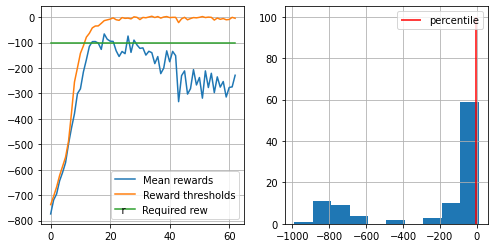

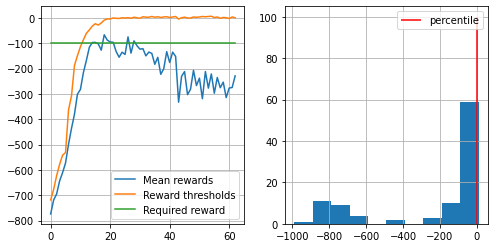

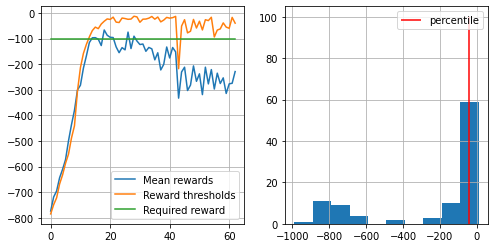

Process Process-14:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-31-fe38c468a610>", line 24, in calculate_iteration_0
    def calculate_iteration_0(): calculate_iteration( 0, 70, 71  );
  File "<ipython-input-31-fe38c468a610>", line 20, in calculate_iteration
    train_session( iter_percentile, iter_learn_rate )
  File "<ipython-input-30-41a253162bb7>", line 25, in train_session
    sessions = [ generate_session( env, policy ) for _ in range( N_SESSIONS ) ]
  File "<ipython-input-30-41a253162bb7>", line 25, in <listcomp>
    sessions = [ generate_session( env, policy ) for _ in range( N_SESSIONS ) ]
Process Process-15:
  File "<ipython-input-5-72aa165340fa>", line 30, in generate_session
    a = np_lib.random.choice( list( range( n_actions ) ), p = policy[ s ] )
 

KeyboardInterrupt: ignored

  File "<ipython-input-30-41a253162bb7>", line 25, in train_session
    sessions = [ generate_session( env, policy ) for _ in range( N_SESSIONS ) ]
  File "<ipython-input-30-41a253162bb7>", line 25, in <listcomp>
    sessions = [ generate_session( env, policy ) for _ in range( N_SESSIONS ) ]
  File "<ipython-input-5-72aa165340fa>", line 33, in generate_session
    new_s, r, done, info = env.step( a )
  File "/usr/local/lib/python3.6/dist-packages/gym/wrappers/time_limit.py", line 18, in step
    if self._elapsed_steps >= self._max_episode_steps:
KeyboardInterrupt


In [31]:
#######################################
# Simple (weak) parallel proccessing  #
#######################################

print("Number of processors: ", mp_lib.cpu_count())

# Define percentile and learn limits
percentile_floor = 0
percentile_top   = 100
percentile_step  = 1; 

learn_rate_floor = 0.5
learn_rate_top   = 1.0

# Define common calculation method
def calculate_iteration( iter_num, floor, top ):
  print( "Process calculate_iteration %d started..." % ( iter_num ) );
  for iter_percentile in range( floor, top, percentile_step ):
    for iter_learn_rate in np_lib.arange( learn_rate_floor, learn_rate_top, 0.1 ): 
      train_session( iter_percentile, iter_learn_rate )
  print( "Process calculate_iteration %d finished..." % ( iter_num ) );

# Define n tasks for parallel ( 10 is more than enought in collab )
def calculate_iteration_0(): calculate_iteration( 0, 70, 71  );
def calculate_iteration_1(): calculate_iteration( 1, 80, 81  );
def calculate_iteration_2(): calculate_iteration( 2, 50, 51  );
def calculate_iteration_3(): calculate_iteration( 3, 30, 40  );
def calculate_iteration_4(): calculate_iteration( 4, 40, 50  );
def calculate_iteration_5(): calculate_iteration( 5, 50, 60  );
def calculate_iteration_6(): calculate_iteration( 6, 60, 70  );
def calculate_iteration_7(): calculate_iteration( 7, 70, 80  );
def calculate_iteration_8(): calculate_iteration( 8, 80, 90  );
def calculate_iteration_9(): calculate_iteration( 9, 90, 100 );

# Parallel tasks execution
def execute_parallel( *tasks ):
  proccesses = []
  
  for task in tasks:
    proc = Process( target = task )
    proc.start()
    proccesses.append(proc)
  
  for join_proc in proccesses: join_proc.join()

execute_parallel( calculate_iteration_0,
                  calculate_iteration_1,
                  calculate_iteration_2 )